# Group 11 - Scenario Discovery

Background information: https://emaworkbench.readthedocs.io/en/latest/indepth_tutorial/open-exploration.html.

## Prepare environment

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from ema_workbench.analysis import prim
from ema_workbench import ema_logging
from ema_workbench.analysis import dimensional_stacking

## Load and prepare data

In [ ]:
# Load and show the data and its shape
data = pd.read_csv('../Output/xxxxxxxx.csv')  #index_col=None)  # CHANGE: data file
print(f"Shape of data: {data.shape[0]} rows, {data.shape[1]} columns.")
data.head()

In [3]:
# Select and show the experiments
x = data.iloc[:, 2:11]                       # CHANGE: experiment condition columns
print(f"Columns in x: {x.columns.values}")

Columns in x: ['Cellulosic cost' 'Total biomass' 'Feedstock distribution'
 'Cellulosic yield' 'Oil elasticity' 'Demand elasticity'
 'Electricity coproduction' 'oil supply shift' 'Biomass backstop price']


In [4]:
# Select the outcome
y = data.iloc[:, 15].values               # CHANGE: outcome column(s)

## Apply PRIM

In [ ]:
# to show progress
ema_logging.log_to_stderr(ema_logging.INFO)

In [5]:
# PRIM algorithm
# Peel alpha controls the leniency of the algorithm, the higher, the less lenient
# The meaning of peel_alpha is the percentile of the data that is to be removed
prim_alg = prim.Prim(x, y, threshold=0.8, peel_alpha=0.1)
# one iteration, to find one box
box1 = prim_alg.find_box()

[MainProcess/INFO] 882 points remaining, containing 89 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.05102040816326531, coverage: 0.5056179775280899, density: 1.0 restricted_dimensions: 6


In [6]:
# Enable matplotlib interactive mode
# %matplotlib notebook

#### Observe coverage density trade-off

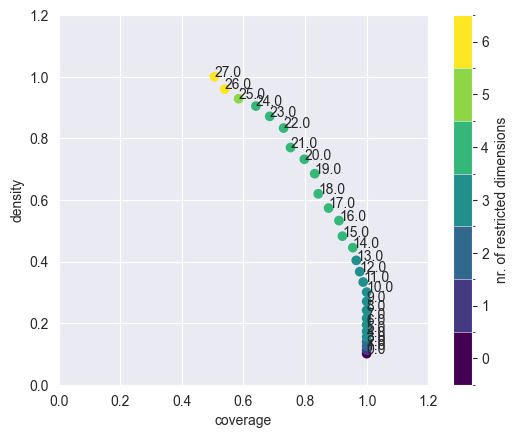

In [7]:
# Observe the trade-off between coverage and density
box1.show_tradeoff(annotated=True)
plt.show()

#### Analyse specific points

We can inspect any of the points on the trade-off curve using the inspect method. As shown, we can show the results either in a table format or in a visual format.

In [8]:
point = 19
box1.inspect(point)

coverage     0.831461
density      0.685185
id          19.000000
mass         0.122449
mean         0.685185
res_dim      4.000000
Name: 19, dtype: float64

                            box 19                                    
                               min         max      qp value  qp value
Total biomass           450.000000  755.799988           NaN  0.000001
Demand elasticity        -0.448500   -0.202000  5.620799e-17       NaN
Biomass backstop price  138.599998  199.600006  3.227320e-10       NaN
Cellulosic cost          72.650002  133.699997  9.570717e-02       NaN



[None]

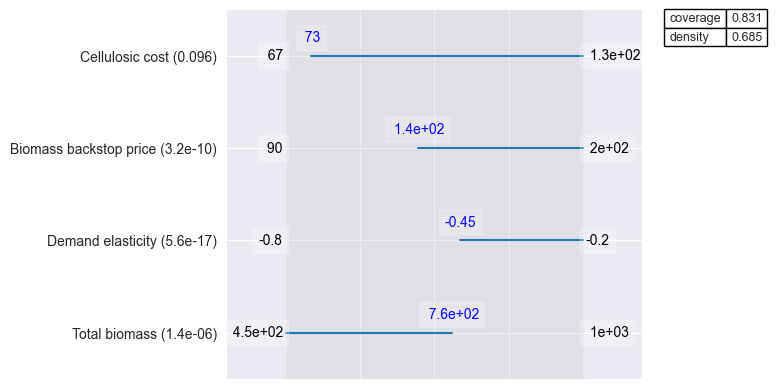

In [9]:
box1.inspect(point, style='graph')
plt.show()

#### Resampling

In [10]:
box1.resample(point)

[MainProcess/INFO] resample 0
[MainProcess/INFO] resample 1
[MainProcess/INFO] resample 2
[MainProcess/INFO] resample 3
[MainProcess/INFO] resample 4
[MainProcess/INFO] resample 5
[MainProcess/INFO] resample 6
[MainProcess/INFO] resample 7
[MainProcess/INFO] resample 8
[MainProcess/INFO] resample 9


,reproduce coverage,reproduce density
Total biomass,100.0,100.0
Demand elasticity,100.0,100.0
Biomass backstop price,100.0,100.0
Cellulosic cost,70.0,60.0
Cellulosic yield,20.0,20.0
Electricity coproduction,20.0,10.0
Feedstock distribution,0.0,0.0
Oil elasticity,0.0,0.0
oil supply shift,0.0,0.0


The resampling shows that for the top 3 parameters we can exactly reproduce coverage and density. This confirms the suggestion of the highly significant quasi p-values in the previous figure. The cellulosic cost is also a relatively reliable indicator with 70% reproduction of coverage and density. The other parameters can be safely ignored when interpreting the results.

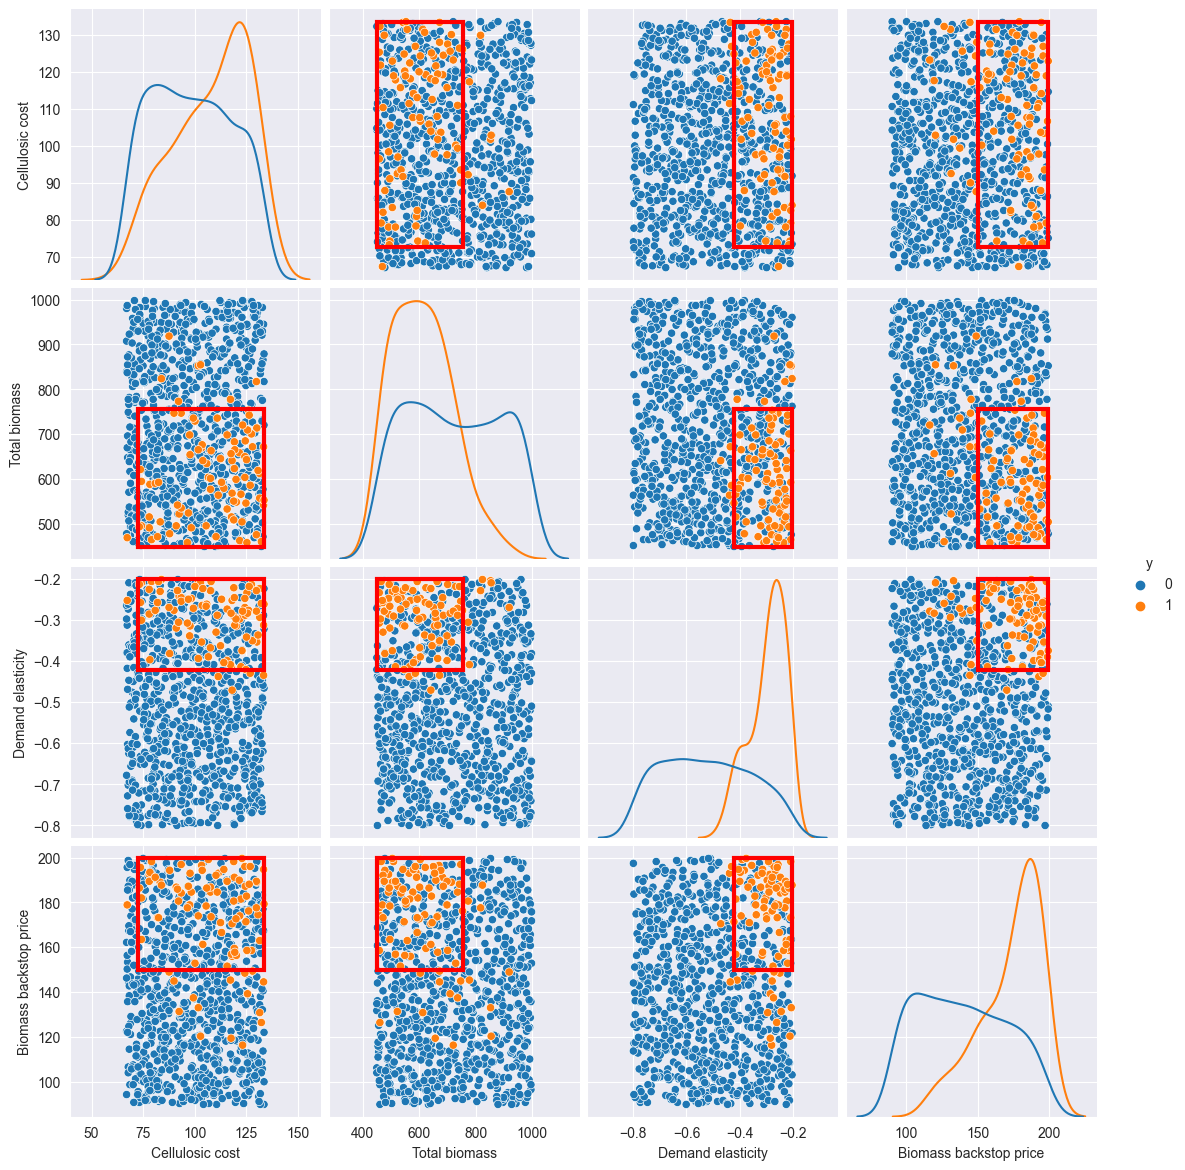

In [11]:
box1.select(21)
box1.show_pairs_scatter()
fig = plt.gcf()
fig.set_size_inches(12,12)
plt.show()

#### Visualize the results using Dimensional Stacking

[MainProcess/INFO] model dropped from analysis because only a single category


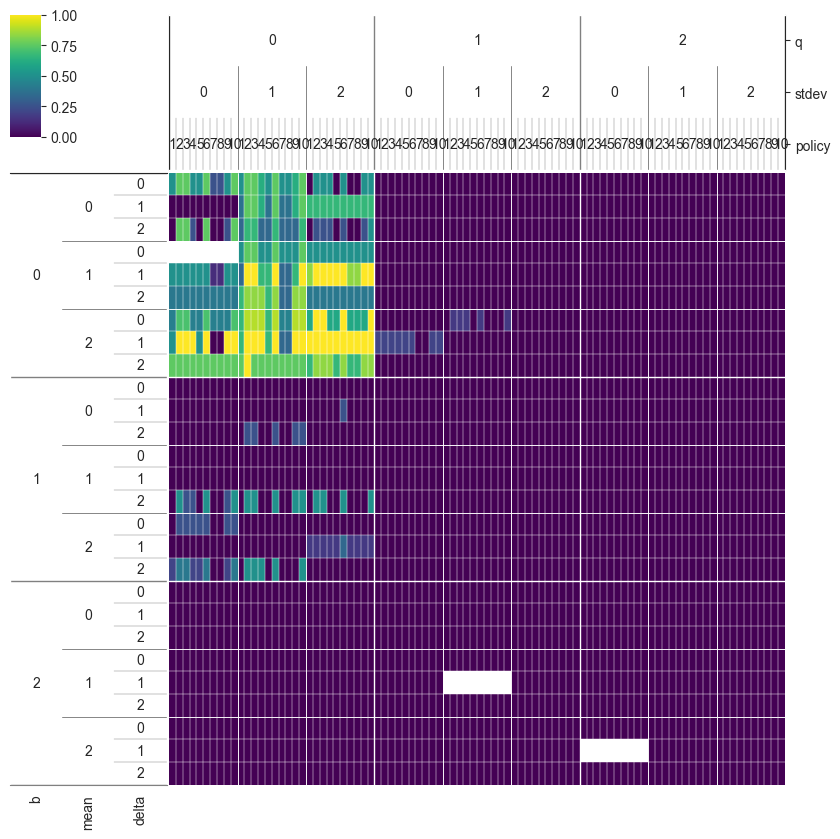

In [10]:
dimensional_stacking.create_pivot_plot(cleaned_experiments, y)

looking at this graph, we have a few white spaces, so there is an argument to be made that we should run quite a bit more than 1000 runs.

In [11]:
n_scenarios = 10000
n_policies = 10

with MultiprocessingEvaluator(lake_model, n_processes=-1) as evaluator:
    results = evaluator.perform_experiments(n_scenarios, n_policies)

[MainProcess/INFO] pool started with 3 workers
[MainProcess/INFO] performing 10000 scenarios * 10 policies * 1 model(s) = 100000 experiments
100%|█████████████████████████████████| 100000/100000 [02:07<00:00, 784.52it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


[MainProcess/INFO] model dropped from analysis because only a single category


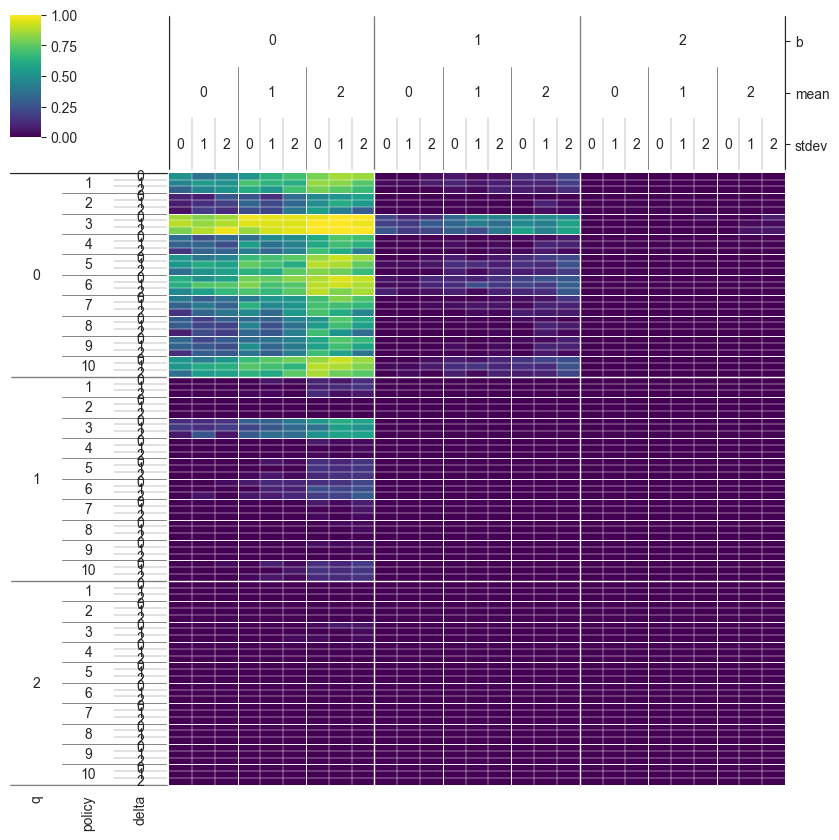

In [12]:
experiments, outcomes = results
cleaned_experiments = experiments.drop(labels=[l.name for l in lake_model.levers], axis=1)

data = outcomes['reliability']
y = data < np.percentile(data, 10)

dimensional_stacking.create_pivot_plot(cleaned_experiments, y)

As you can see, with the additional runs there are at least no white spaces left anymore. This is a good indication that we have a good coverage of the space.